In [ ]:
!pip install Unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 8.1 MB/s eta 0:00:00


In [2]:
from unidecode import unidecode

import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore') 

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
!unzip -qq '/content/drive/MyDrive/Dacon/제2회 코스포 x 데이콘 도서 추천 알고리즘 AI경진대회(채용 연계형)/open.zip'

In [4]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

In [5]:
train.head()

,ID,User-ID,Book-ID,Book-Rating,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,TRAIN_000000,USER_00000,BOOK_044368,8,23.0,"sackville, new brunswick, canada",Road Taken,Rona Jaffe,2001.0,Mira
1,TRAIN_000001,USER_00000,BOOK_081205,8,23.0,"sackville, new brunswick, canada",Macbeth (New Penguin Shakespeare),William Shakespeare,1981.0,Penguin Books
2,TRAIN_000002,USER_00000,BOOK_086781,0,23.0,"sackville, new brunswick, canada",Waverley (Penguin English Library),Walter Scott,1981.0,Penguin Books
3,TRAIN_000003,USER_00000,BOOK_098622,0,23.0,"sackville, new brunswick, canada",Mother Earth Father Sky,Sue Harrison,1991.0,Avon
4,TRAIN_000004,USER_00000,BOOK_180810,8,23.0,"sackville, new brunswick, canada",She Who Remembers,Linda Lay Shuler,1989.0,Signet Book


0. 모든 데이터 소문자로 변경
1. 나이대 범주형으로 변경 
    - 10대 이하, 10, 20, 30, 40, 50, 60대 이상
    - 이상치 제거(2세 이하, 101세 이상)
2. 국가 칼럼에 국가 할당
    - pycountry 사용해 pycountry에 있을 경우
    - 없으면 NaN
    - 또는 결측치만 처리한 뒤 토크나이저
3. 년도 범주형으로 번경
    - 그래프로 년도별로 시각화한 뒤 결정 예정
4. 제목, 작가 이름 불용어 처리, 특수문자 제거
    - 띄어쓰기를 하나로 통일

In [ ]:
len(train)

871393

In [ ]:
train.loc[(train['Age'] > 100) | (train['Age'] < 3), 'Age'] = np.nan    
# 평균값으로 대체
train['Age'] = train['Age'].fillna(train['Age'].mean())
train["Age_Category"] = pd.cut(train["Age"], bins=[0, 9, 19, 29, 39, 49, 59, max(train["Age"])], right=True, labels=['10대 이하', '10대', '20대', '30대', '40대', '50대', '60대 이상'])

In [ ]:
len(train)

867686

In [ ]:
train.head()

,ID,User-ID,Book-ID,Book-Rating,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age_Category
0,TRAIN_000000,USER_00000,BOOK_044368,8,23.0,"sackville, new brunswick, canada",Road Taken,Rona Jaffe,2001.0,Mira,20대
1,TRAIN_000001,USER_00000,BOOK_081205,8,23.0,"sackville, new brunswick, canada",Macbeth (New Penguin Shakespeare),William Shakespeare,1981.0,Penguin Books,20대
2,TRAIN_000002,USER_00000,BOOK_086781,0,23.0,"sackville, new brunswick, canada",Waverley (Penguin English Library),Walter Scott,1981.0,Penguin Books,20대
3,TRAIN_000003,USER_00000,BOOK_098622,0,23.0,"sackville, new brunswick, canada",Mother Earth Father Sky,Sue Harrison,1991.0,Avon,20대
4,TRAIN_000004,USER_00000,BOOK_180810,8,23.0,"sackville, new brunswick, canada",She Who Remembers,Linda Lay Shuler,1989.0,Signet Book,20대


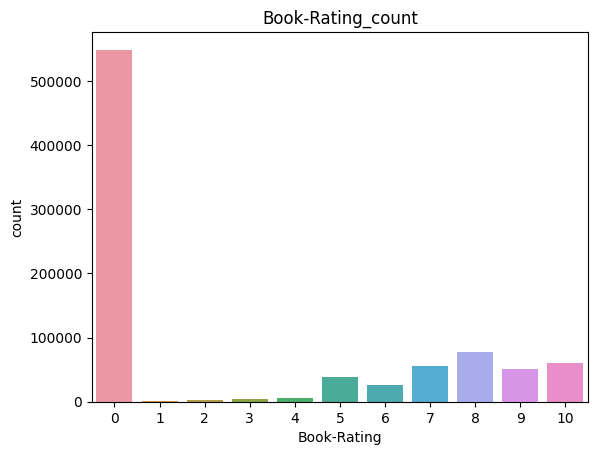

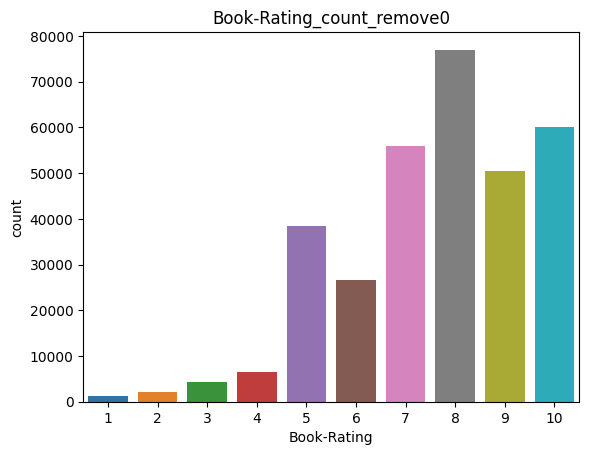

In [6]:
sns.countplot(x = train["Book-Rating"])
plt.title("Book-Rating_count")
plt.show()
sns.countplot(x = train["Book-Rating"].loc[train["Book-Rating"] != 0])
plt.title("Book-Rating_count_remove0")
plt.show()

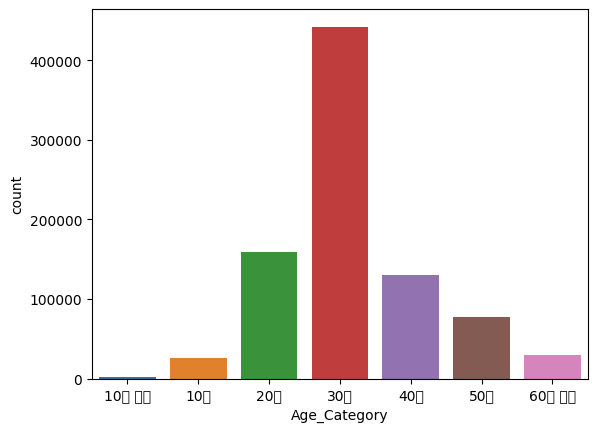

In [ ]:
sns.countplot(x= train["Age_Category"])
plt.show()

In [ ]:
train2 = train.copy()
test2 = test.copy()

In [ ]:
train2.loc[train2["Location"] == "?????, arizona, usa"]

,ID,User-ID,Book-ID,Book-Rating,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age_Category
501858,TRAIN_501858,USER_53534,BOOK_168657,9,35.0,"?????, arizona, usa",Family of Light: Pleiadian Tales and Lessons i...,Barbara Marciniak,1998.0,Bear &amp; Company,30대


In [ ]:
## Location Book-Title	Book-Author, Publisher
# 소문자로 변경
train2["Location"] = train2["Location"].apply(lambda ba : ba.lower())
train2["Book-Title"] = train2["Book-Title"].apply(lambda ba : ba.lower())
train2["Book-Author"] = train2["Book-Author"].apply(lambda ba : ba.lower())
train2["Publisher"] = train2["Publisher"].apply(lambda ba : ba.lower())

In [ ]:


# 프랑스어 영어로 변경
train2["Location"] = train2["Location"].apply(lambda ba : ba.encode('ISO-8859-1').decode('utf-8', 'ignore'))
train2["Book-Title"] = train2["Book-Title"].apply(lambda ba : ba.encode('ISO-8859-1').decode('utf-8', 'ignore'))
train2["Book-Author"] = train2["Book-Author"].apply(lambda ba : ba.encode('ISO-8859-1').decode('utf-8', 'ignore'))
train2["Publisher"] = train2["Publisher"].apply(lambda ba : ba.encode('ISO-8859-1').decode('utf-8', 'ignore'))


train2["Location"] = train2["Location"].apply(lambda ba : unidecode(ba))
train2["Book-Title"] = train2["Book-Title"].apply(lambda ba : unidecode(ba))
train2["Book-Author"] = train2["Book-Author"].apply(lambda ba : unidecode(ba))
train2["Publisher"] = train2["Publisher"].apply(lambda ba : unidecode(ba))


In [ ]:
train2.head(30)

,ID,User-ID,Book-ID,Book-Rating,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age_Category
0,TRAIN_000000,USER_00000,BOOK_044368,8,23.0,"sackville, new brunswick, canada",road taken,rona jaffe,2001.0,mira,20대
1,TRAIN_000001,USER_00000,BOOK_081205,8,23.0,"sackville, new brunswick, canada",macbeth (new penguin shakespeare),william shakespeare,1981.0,penguin books,20대
2,TRAIN_000002,USER_00000,BOOK_086781,0,23.0,"sackville, new brunswick, canada",waverley (penguin english library),walter scott,1981.0,penguin books,20대
3,TRAIN_000003,USER_00000,BOOK_098622,0,23.0,"sackville, new brunswick, canada",mother earth father sky,sue harrison,1991.0,avon,20대
4,TRAIN_000004,USER_00000,BOOK_180810,8,23.0,"sackville, new brunswick, canada",she who remembers,linda lay shuler,1989.0,signet book,20대
5,TRAIN_000005,USER_00000,BOOK_206799,5,23.0,"sackville, new brunswick, canada",neuromancer (remembering tomorrow),william gibson,1995.0,ace books,20대
6,TRAIN_000006,USER_00000,BOOK_239414,9,23.0,"sackville, new brunswick, canada",the little prince,antoine de saint-exupry,1982.0,harvest books,20대
7,TRAIN_000007,USER_00000,BOOK_269070,0,23.0,"sackville, new brunswick, canada",forests of the heart (newford),charles de lint,2001.0,tor books,20대
8,TRAIN_000008,USER_00001,BOOK_190739,7,35.0,"wake forest, north carolina, usa",self matters : creating your life from the ins...,phillip c. mcgraw,2001.0,free press,30대
9,TRAIN_000009,USER_00001,BOOK_210079,0,35.0,"wake forest, north carolina, usa",the self matters companion : helping you creat...,phillip c. mcgraw,2002.0,free press,30대


In [ ]:
# 특수문자 제거
train2["Location"] = train2["Location"].apply(lambda ba : re.sub(r'[^a-zA-Z\s,?]', '', ba))
train2["Book-Title"] = train2["Book-Title"].apply(lambda ba : re.sub(r'[^a-zA-Z\s1234567890]', '', ba))
train2["Book-Author"] = train2["Book-Author"].apply(lambda ba : re.sub(r'[^a-zA-Z\s]', '', ba))
train2["Publisher"] = train2["Publisher"].apply(lambda ba : re.sub(r'[^a-zA-Z\s1234567890]', '', ba))


In [ ]:
# location 결측치 확인
arr = []
stop_loc = []
for i in train2["Location"]:
    for j in i.split(","):
        j = j.strip()
        if len(j) == 1 or j == "":
            if j not in stop_loc:
                stop_loc.append(j)
        else:
            if j not in arr:
                arr.append(j)


In [ ]:
for i in range(2, 11):
    stop_loc.append("x"*i)

In [ ]:
train2["Location2"] = train2["Location"]

In [ ]:

for idx, i in enumerate(train2["Location2"]):
    sentences = ''
    for j in i.split(","):
        j = j.rstrip()
        if j not in stop_loc:
            sentences += j
    train2["Location2"].iloc[idx] = sentences

In [ ]:
train2.head(30)

In [ ]:
test2 = test2.copy()
test2.loc[(test2['Age'] > 100) | (test2['Age'] < 3), 'Age'] = np.nan    
# 평균값으로 대체
test2['Age'] = test2['Age'].fillna(train2['Age'].mean())

test2["Age_Category"] = pd.cut(test2["Age"], bins=[0, 9, 19, 29, 39, 49, 59, max(test2["Age"])], right=True, labels=['10대 이하', '10대', '20대', '30대', '40대', '50대', '60대 이상'])

## Location Book-Title	Book-Author, Publisher
# 소문자로 변경
test2["Location"] = test2["Location"].apply(lambda ba : ba.lower())
test2["Book-Title"] = test2["Book-Title"].apply(lambda ba : ba.lower())
test2["Book-Author"] = test2["Book-Author"].apply(lambda ba : ba.lower())
test2["Publisher"] = test2["Publisher"].apply(lambda ba : ba.lower())

# 프랑스어 영어로 변경
test2["Location"] = test2["Location"].apply(lambda ba : ba.encode('ISO-8859-1').decode('utf-8', 'ignore'))
test2["Book-Title"] = test2["Book-Title"].apply(lambda ba : ba.encode('ISO-8859-1').decode('utf-8', 'ignore'))
test2["Book-Author"] = test2["Book-Author"].apply(lambda ba : ba.encode('ISO-8859-1').decode('utf-8', 'ignore'))
test2["Publisher"] = test2["Publisher"].apply(lambda ba : ba.encode('ISO-8859-1').decode('utf-8', 'ignore'))


test2["Location"] = test2["Location"].apply(lambda ba : unidecode(ba))
test2["Book-Title"] = test2["Book-Title"].apply(lambda ba : unidecode(ba))
test2["Book-Author"] = test2["Book-Author"].apply(lambda ba : unidecode(ba))
test2["Publisher"] = test2["Publisher"].apply(lambda ba : unidecode(ba))

# 특수문자 제거
# 제목과 출판사에 숫자만 있는 경우도 있기 때문에 숫자 제외(예 : 1984)
test2["Location"] = test2["Location"].apply(lambda ba : re.sub(r'[^a-zA-Z\s,?]', '', ba))
test2["Book-Title"] = test2["Book-Title"].apply(lambda ba : re.sub(r'[^a-zA-Z\s1234567890]', '', ba))
test2["Book-Author"] = test2["Book-Author"].apply(lambda ba : re.sub(r'[^a-zA-Z\s]', '', ba))
test2["Publisher"] = test2["Publisher"].apply(lambda ba : re.sub(r'[^a-zA-Z\s1234567890]', '', ba))

test2["Location2"] = test2["Location"]

# 공백 제거
for idx, i in enumerate(test2["Location2"]):
    sentences = ''
    for j in i.split(","):
        j = j.rstrip()
        if j not in stop_loc:
            sentences += j
    test2["Location2"].iloc[idx] = sentences

In [ ]:
stop_words = ['q','w','e','r','t', 'y', 'u', 'i', 'o', 'p', 'a', 's', 'd', 'f', 'g', 'h', 'j', 'k', 'l', 'z', 'x', 'c', 'v', 'b', 'n', 'm']

In [ ]:
train2['Book-Title_stop_words'] = train2['Book-Title']
test2['Book-Title_stop_words'] = test2['Book-Title']

In [ ]:
train2['Book-Title'] = train2['Book-Title_stop_words'].apply(lambda x: ' '.join([word.strip() for word in x.split() if word not in stop_words]))
test2['Book-Title'] = test2['Book-Title_stop_words'].apply(lambda x: ' '.join([word.strip() for word in x.split() if word not in stop_words]))

In [ ]:
train2.to_csv("/content/drive/MyDrive/Dacon/제2회 코스포 x 데이콘 도서 추천 알고리즘 AI경진대회(채용 연계형)/prepro_0428_alive_number_train.csv")
test2.to_csv("/content/drive/MyDrive/Dacon/제2회 코스포 x 데이콘 도서 추천 알고리즘 AI경진대회(채용 연계형)/prepro_0428_alive_number_test.csv")